# Promotional Posts: Trend Calibration
Using Facebook Prophet's cross-validation tool, we assess prediction performance on a horizon of 365 days by training the model on the first 365 days of the data set then making predictions every 180 days. For our case, we only need 1 forecast from 2-27-2019 to 2-27-2020.

## Method
The objective of this analysis is to determine the optimal changepoint value parameter when instantiating the Prophet model object. This is done by plotting a range of changepoint values vs the average margin error. The changepoint value with the lowest average margin error will be the optimal parameter for the Prophet model.

First, we create a range of changepoint values that produce a viable trend model. Next, we loop through the range, test the model using each value, and produce a cross-valudation data frame containing actual and predicted y-values. From there, we take the columns for y-actual and y-predicted and calculate the error margin for each row: 

``` (actual - theoretical)/theoretical ``` 

Lastly, we create a plot of changepoint values vs average margin error.

## Steps
1. Clean/Re-label DataFrame and Isolate one criterion for the outcome column (i.e. "Impressions").
1. Create and Loop through a range of viable changepoint values.
1. Test Prophet Object (Model) with each changepoint value.
1. Plot changepoint values vs average margin error

### Import Dependencies

In [113]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation


import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from numpy import mean

In [2]:
#Read Master CSV
goldie_df = pd.read_csv("goldie_master_cleaned_0314.csv")
goldie_df.head()

,Unnamed: 0,Tweet permalink,Tweet text,Type,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,permalink clicks,follows,media views,media engagements
0,0,https://twitter.com/GoldieChan/status/94776617...,HAPPY NEW YEAR 🎉\nMay all your dreams come tru...,2.0,2018-01-01 09:47:00+00:00,532.0,11.0,0.020677,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0,45,6
1,1,https://twitter.com/GoldieChan/status/94825542...,“I've learned that you shouldn't go through li...,3.0,2018-01-02 18:11:00+00:00,409.0,6.0,0.014670,2.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0,0,0
2,2,https://twitter.com/GoldieChan/status/94829378...,This 👇 https://t.co/4niBsvseUQ,1.0,2018-01-02 20:43:00+00:00,366.0,1.0,0.002732,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,3,https://twitter.com/GoldieChan/status/94835616...,Where should I go next? #travel https://t.co/D...,3.0,2018-01-03 00:51:00+00:00,465.0,7.0,0.015054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,7
4,4,https://twitter.com/GoldieChan/status/94840888...,DONE with first day of #work back. Current fee...,2.0,2018-01-03 04:21:00+00:00,528.0,12.0,0.022727,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,11,11


In [3]:
#Changing Date/Time to "YYYY-MM-DD" format
goldie_df['year'] = pd.to_datetime(goldie_df['time']).dt.year.astype(str)
goldie_df['month'] = pd.to_datetime(goldie_df['time']).dt.month.astype(str)
goldie_df['day'] = pd.to_datetime(goldie_df['time']).dt.day.astype(str)

goldie_df['date'] = goldie_df[['year', 'month', 'day']].agg('-'.join, axis=1)
goldie_df = goldie_df.drop(columns = ["year", "month", "day"])
goldie_df = goldie_df.drop(columns = "time")

In [4]:
goldie_df.head()

,Unnamed: 0,Tweet permalink,Tweet text,Type,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,permalink clicks,follows,media views,media engagements,date
0,0,https://twitter.com/GoldieChan/status/94776617...,HAPPY NEW YEAR 🎉\nMay all your dreams come tru...,2.0,532.0,11.0,0.020677,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0,45,6,2018-1-1
1,1,https://twitter.com/GoldieChan/status/94825542...,“I've learned that you shouldn't go through li...,3.0,409.0,6.0,0.014670,2.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0,0,0,2018-1-2
2,2,https://twitter.com/GoldieChan/status/94829378...,This 👇 https://t.co/4niBsvseUQ,1.0,366.0,1.0,0.002732,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,2018-1-2
3,3,https://twitter.com/GoldieChan/status/94835616...,Where should I go next? #travel https://t.co/D...,3.0,465.0,7.0,0.015054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,7,2018-1-3
4,4,https://twitter.com/GoldieChan/status/94840888...,DONE with first day of #work back. Current fee...,2.0,528.0,12.0,0.022727,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,11,11,2018-1-3


In [5]:
#Identify and Drop the Biggest Outlier
sample = goldie_df.sort_values(by=["impressions"], ascending=False)
sample.head()

,Unnamed: 0,Tweet permalink,Tweet text,Type,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,permalink clicks,follows,media views,media engagements,date
6258,6258,https://twitter.com/GoldieChan/status/11768922...,So excited that @Forbes shared my article on @...,1.0,608789.0,38345.0,0.062986,71.0,13.0,907.0,2077.0,753.0,0.0,459.0,0.0,1,34064,34064,2019-9-25
6779,6779,https://twitter.com/GoldieChan/status/11839781...,My next few 💚 talks &amp; livestreams:\n✨ #Vid...,2.0,283615.0,85.0,0.000300,11.0,1.0,22.0,10.0,0.0,1.0,11.0,0.0,0,491,29,2019-10-15
4798,4798,https://twitter.com/GoldieChan/status/11527092...,On a magical journey with #Funko Mira of @dark...,2.0,221055.0,6372.0,0.028825,42.0,3.0,339.0,172.0,80.0,18.0,230.0,0.0,0,5488,5488,2019-7-20
7426,7426,https://twitter.com/GoldieChan/status/11926178...,We’re on the red carpet for @OriginalFunko #Ho...,2.0,218574.0,3854.0,0.017632,16.0,11.0,216.0,387.0,17.0,55.0,268.0,0.0,0,2884,2884,2019-11-8
4797,4797,https://twitter.com/GoldieChan/status/11526773...,Always an absolute joy to collaborate with one...,2.0,209145.0,5912.0,0.028267,13.0,3.0,205.0,276.0,67.0,25.0,213.0,0.0,0,5110,5110,2019-7-20


In [6]:
goldie_df = goldie_df.drop([6258])

In [7]:
#Promotion Posts
promos = goldie_df.copy()
promos_df = promos[promos["Type"] == 1]
promos_df.head()

,Unnamed: 0,Tweet permalink,Tweet text,Type,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,permalink clicks,follows,media views,media engagements,date
2,2,https://twitter.com/GoldieChan/status/94829378...,This 👇 https://t.co/4niBsvseUQ,1.0,366.0,1.0,0.002732,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,2018-1-2
10,10,https://twitter.com/GoldieChan/status/95000583...,Let's celebrate the Lunar #YearoftheDog with a...,1.0,368.0,4.0,0.010870,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0,0,0,2018-1-7
11,11,https://twitter.com/GoldieChan/status/95017896...,At @CES!! The green-haired Oprah of @LinkedIn ...,1.0,954.0,43.0,0.045073,2.0,0.0,10.0,5.0,1.0,0.0,3.0,0.0,0,115,22,2018-1-8
21,21,https://twitter.com/GoldieChan/status/95223729...,Let's visit the totally pinnable @Pinterest in...,1.0,352.0,3.0,0.008523,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0,0,0,2018-1-13
22,22,https://twitter.com/GoldieChan/status/95228875...,Some of the green murals in #ClarionAlley in S...,1.0,1203.0,12.0,0.009975,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0,110,10,2018-1-13


## Calibrate Model for Impressions of Promotional Posts

In [8]:
#Promotions Impressions cleaned
promo_impr_df = promos_df[["date", "impressions"]]
promo_impr_df = promo_impr_df.rename(columns = {"date": "ds", "impressions": "y"})
promo_impr_df.head()

,ds,y
2,2018-1-2,366.0
10,2018-1-7,368.0
11,2018-1-8,954.0
21,2018-1-13,352.0
22,2018-1-13,1203.0


In [9]:
#Check for Outstanding Outliers
promo_impr_df.sort_values(by=['y'], ascending=False).head()

,ds,y
6275,2019-9-26,142863.0
8087,2019-12-1,134646.0
5378,2019-8-19,61001.0
7970,2019-11-25,50004.0
6066,2019-9-17,45886.0


In [20]:
#Drop Outstanding Outliers to fix skew
# promo_impr_df = promo_impr_df.drop([7426])
promo_impr_df = promo_impr_df[promo_impr_df['y'].between(0,20000)]

In [21]:
#Check new df
promo_impr_df.sort_values(by=['y'], ascending=False).head()

,ds,y
7697,2019-11-13,19875.0
5425,2019-8-20,19237.0
4244,2019-6-21,17500.0
7221,2019-11-1,16729.0
4808,2019-7-21,16191.0


### Create a range of viable changepoint values for Impressions

In [170]:
x_impr = np.arange(0.08, 2.1, 0.1)
x_impr

array([0.08, 0.18, 0.28, 0.38, 0.48, 0.58, 0.68, 0.78, 0.88, 0.98, 1.08,
       1.18, 1.28, 1.38, 1.48, 1.58, 1.68, 1.78, 1.88, 1.98, 2.08])

### Loop through range of changepoint values
We test the model by tuning the changepoint parameter to each value in the range above.

Produce a prediction dataframe, then isolate y-actual and y-theoretical values, and calculate margin error per entry. Take the mean of all the margin errors and append to list; this list will be the y values for the plot below.

In [201]:
y = []
avg = []
for val in x_impr:
    m_promo_impr = Prophet(yearly_seasonality=True, changepoint_prior_scale=val)
    m_promo_impr.fit(promo_impr_df)
    future_promo_impr = m_promo_impr.make_future_dataframe(periods=365)
    forecast_promo_impr = m_promo_impr.predict(future_promo_impr)
    df_cv = cross_validation(m_promo_impr, initial='366 days', period='180 days', horizon = '365 days')
    y_zipped = zip(df_cv["y"], df_cv["yhat"])
    for a,b in y_zipped:
        x = (a-b)/b
        y.append(abs(x))

    avg.append(mean(y))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:0

#### Plot Changepoint parameter values vs Average Error Margin

Text(0, 0.5, 'Error Margin')

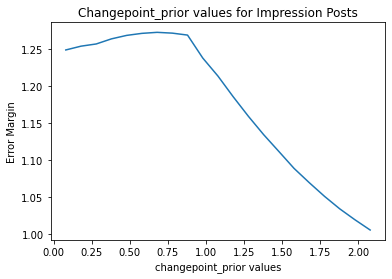

In [203]:
plt.plot(x_impr,avg)
plt.title("Changepoint_prior values for Impression Posts")
plt.xlabel("changepoint_prior values")
plt.ylabel("Error Margin")

For Impressions, optimal changepoint value is 2.08

## Calibrate Model for Clicks of Promotional Posts

In [153]:
#Promotions Clicks DF
promo_click_df = promos_df[["date", "url clicks"]]
promo_click_df.sort_values(by=["url clicks"], ascending=False)

,date,url clicks
7970,2019-11-25,1464.0
9544,2020-1-31,1062.0
5378,2019-8-19,582.0
6066,2019-9-17,354.0
5425,2019-8-20,327.0
...,...,...
2401,2019-1-29,0.0
2427,2019-2-2,0.0
2440,2019-2-5,0.0
2447,2019-2-5,0.0


In [177]:
#Exclude Outliers
promo_click_df = promo_click_df[promo_click_df['y'].between(0,200)]

In [178]:
#Promotion Clicks Cleaned
promo_click_df = promo_click_df.rename(columns = {"date": "ds", "url clicks": "y"})
promo_click_df.head()

,ds,y
2,2018-1-2,0.0
10,2018-1-7,0.0
11,2018-1-8,1.0
21,2018-1-13,0.0
22,2018-1-13,0.0


#### Create range of viable changepoint values for Clicks

In [180]:
x_clicks = np.arange(0.1, 1.01, 0.1)
x_clicks

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [204]:
y_clicks= []
avg_clicks = []
for val in x_clicks:
    m_promo_clicks = Prophet(yearly_seasonality=True, changepoint_prior_scale=val)
    m_promo_clicks.fit(promo_click_df)
    future_promo_clicks = m_promo_clicks.make_future_dataframe(periods=365)
    forecast_promo_clicks = m_promo_clicks.predict(future_promo_clicks)
    df_cv_clicks = cross_validation(m_promo_clicks, initial='366 days', period='180 days', horizon = '365 days')
    y_zipped_clicks = zip(df_cv_clicks["y"], df_cv_clicks["yhat"])
    for a,b in y_zipped_clicks:
        marg_error_clicks = (a-b)/b
        y_clicks.append(abs(marg_error_clicks))

    avg_clicks.append(mean(y_clicks))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:0

In [205]:
avg_clicks

[3.1715368985198804,
 3.1638872964264566,
 3.1482158881103173,
 3.146819383328942,
 3.147444846509266,
 3.153597272052343,
 3.179994164200227,
 3.210547365659386,
 3.2322416612392924,
 3.2937706281939696]

#### Plot Changepoint parameter values vs Average Error Margin

Text(0, 0.5, 'Error Margin')

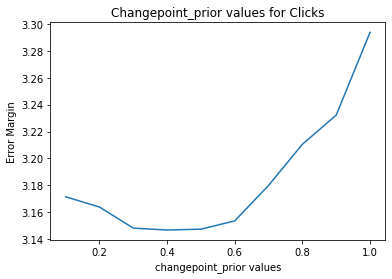

In [206]:
plt.plot(x_clicks,avg_clicks)
plt.title("Changepoint_prior values for Clicks")
plt.xlabel("changepoint_prior values")
plt.ylabel("Error Margin")

For Clicks, optimal changepoint value is 0.4

### Calibrate Model for Retweets of Promotional Posts

In [207]:
#Create Data Frame for Retweet Data on Promotional Posts
promo_retweet_df = promos_df[["date", "retweets"]]
promo_retweet_df.sort_values(by=["retweets"], ascending=False)

,date,retweets
7970,2019-11-25,97.0
7697,2019-11-13,69.0
5378,2019-8-19,68.0
5425,2019-8-20,39.0
6066,2019-9-17,33.0
...,...,...
906,2018-6-25,0.0
4120,2019-6-18,0.0
916,2018-6-27,0.0
4066,2019-6-17,0.0


In [219]:
#Promotion Retweets DF Cleaned
promo_retweet_df = promo_retweet_df.rename(columns = {"date": "ds", "retweets": "y"})
promo_retweet_df.head()


,ds,y
2,2018-1-2,0.0
10,2018-1-7,0.0
11,2018-1-8,2.0
21,2018-1-13,0.0
22,2018-1-13,0.0


In [220]:
#Exclude outliers
promo_retweet_df = promo_retweet_df[promo_retweet_df['y'].between(0,20)]


#### Create range of viable changepoint values for retweets

In [221]:
x_retweets = np.arange(0.2, 1, 0.1)
x_retweets

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [222]:
y_retweets= []
avg_retweets = []
for val in x_retweets:
    m_promo_retweets = Prophet(yearly_seasonality=True, changepoint_prior_scale=val)
    m_promo_retweets.fit(promo_retweet_df)
    future_promo_retweets = m_promo_retweets.make_future_dataframe(periods=365)
    forecast_promo_retweets = m_promo_retweets.predict(future_promo_retweets)
    df_cv_retweets = cross_validation(m_promo_retweets, initial='366 days', period='180 days', horizon = '365 days')
    y_zipped_retweets = zip(df_cv_retweets["y"], df_cv_retweets["yhat"])
    for a,b in y_zipped_retweets:
        marg_error_retweets = (a-b)/b
        y_retweets.append(abs(marg_error_retweets))

    avg_retweets.append(mean(y_retweets))
    
avg_retweets

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:0

[1.2924546663551608,
 1.2823680400998918,
 1.2762044002751203,
 1.2727270566605409,
 1.2703215590403916,
 1.2699259263101452,
 1.2686757682870837,
 1.2683830272020071]

#### Plot Changepoint Parameter vs Average Error Margin

Text(0, 0.5, 'Average Error Margin')

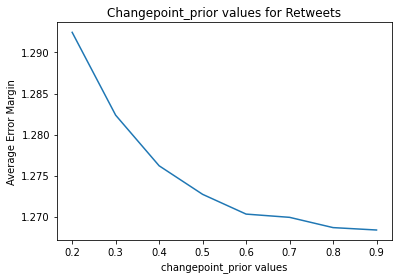

In [233]:
plt.plot(x_retweets,avg_retweets)
plt.title("Changepoint_prior values for Retweets")
plt.xlabel("changepoint_prior values")
plt.ylabel("Average Error Margin")

For Retweets, optimal changepoint value is 0.9

## Calibrate Model for Likes of Promotional Posts

In [225]:
#Create Data Frame for Like Data on Promotional Posts
promo_like_df = promos_df[["date", "likes"]]
promo_like_df.sort_values(by=["likes"], ascending=False)

,date,likes
7697,2019-11-13,458.0
7970,2019-11-25,448.0
5378,2019-8-19,307.0
6275,2019-9-26,191.0
5425,2019-8-20,152.0
...,...,...
397,2018-4-17,0.0
4278,2019-6-24,0.0
1603,2018-10-6,0.0
245,2018-3-27,0.0


In [226]:
#Promotion Likes DF Cleaned

In [227]:
promo_like_df = promo_like_df.rename(columns = {"date": "ds", "likes": "y"})
promo_like_df.head()

,ds,y
2,2018-1-2,1.0
10,2018-1-7,1.0
11,2018-1-8,10.0
21,2018-1-13,3.0
22,2018-1-13,2.0


In [228]:
#Exclude outliers
promo_like_df = promo_like_df[promo_like_df['y'].between(0,100)]


#### Create range of viable changepoint values for Likes

In [229]:
x_likes = np.arange(0.7, 2.1, 0.1)
x_likes

array([0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9,
       2. ])

In [230]:
y_likes= []
avg_likes = []
for val in x_likes:
    m_promo_likes = Prophet(yearly_seasonality=True, changepoint_prior_scale=val)
    m_promo_likes.fit(promo_retweet_df)
    future_promo_likes = m_promo_likes.make_future_dataframe(periods=365)
    forecast_promo_likes = m_promo_likes.predict(future_promo_likes)
    df_cv_likes = cross_validation(m_promo_likes, initial='366 days', period='180 days', horizon = '365 days')
    y_zipped_likes = zip(df_cv_likes["y"], df_cv_likes["yhat"])
    for a,b in y_zipped_likes:
        marg_error_likes = (a-b)/b
        y_likes.append(abs(marg_error_likes))

    avg_likes.append(mean(y_likes))
    
avg_likes

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:0

[1.2679477632137919,
 1.2645541031187766,
 1.2651473521657317,
 1.265497067955259,
 1.2653535507550833,
 1.2653228310460667,
 1.2655534771478172,
 1.2655601511310999,
 1.2655854720539315,
 1.2654699742361553,
 1.2654046921767514,
 1.2653088507031238,
 1.2650782317751181,
 1.2648692703933524]

#### Plot Changepoint Parameter vs Average Error Margin

Text(0, 0.5, 'Average Error Margin')

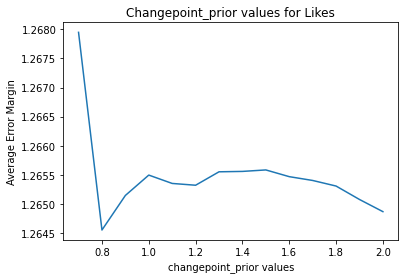

In [236]:
plt.plot(x_likes,avg_likes)
plt.title("Changepoint_prior values for Likes")
plt.xlabel("changepoint_prior values")
plt.ylabel("Average Error Margin")

For Likes, optimal changepoint value is 0.8

## Calibrate Model for Replies of Promotional Posts

In [280]:
#Create Data Frame for Like Data on Promotional Posts
promo_replies_df = promos_df[["date", "replies"]]
promo_replies_df.sort_values(by=["replies"], ascending=False)

,date,replies
6333,2019-9-27,21.0
7426,2019-11-8,11.0
3236,2019-5-1,8.0
4994,2019-7-30,7.0
931,2018-6-28,7.0
...,...,...
1426,2018-9-14,0.0
1409,2018-9-12,0.0
1348,2018-9-5,0.0
1291,2018-9-2,0.0


In [281]:
#Promotion Likes DF Cleaned
promo_replies_df = promo_replies_df.rename(columns = {"date": "ds", "replies": "y"})
promo_replies_df.head()

,ds,y
2,2018-1-2,0.0
10,2018-1-7,1.0
11,2018-1-8,0.0
21,2018-1-13,0.0
22,2018-1-13,0.0


#### Create range of viable changepoint values for Replies

In [235]:
x_replies = np.arange(0.5, 2.1, 0.1)
x_replies

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. ])

In [237]:
y_replies= []
avg_replies = []
for val in x_replies:
    m_promo_replies = Prophet(yearly_seasonality=True, changepoint_prior_scale=val)
    m_promo_replies.fit(promo_retweet_df)
    future_promo_replies = m_promo_replies.make_future_dataframe(periods=365)
    forecast_promo_replies = m_promo_replies.predict(future_promo_replies)
    df_cv_replies = cross_validation(m_promo_replies, initial='366 days', period='180 days', horizon = '365 days')
    y_zipped_replies = zip(df_cv_replies["y"], df_cv_replies["yhat"])
    for a,b in y_zipped_replies:
        marg_error_replies = (a-b)/b
        y_replies.append(abs(marg_error_replies))

    avg_replies.append(mean(y_replies))
    
avg_replies

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-02-27 00:0

[1.2634157481285602,
 1.2620680200924121,
 1.2640279344662053,
 1.2633110616055945,
 1.263915619336404,
 1.2643540520009768,
 1.2644148277086058,
 1.2645091283076528,
 1.264778931135505,
 1.2648617249233622,
 1.2649459353336554,
 1.2649029818788646,
 1.26489135800993,
 1.2648719183877164,
 1.2647011774711385,
 1.2645419021560922]

#### Plot Changepoint Parameter vs Average Error Margin

Text(0, 0.5, 'Average Error Margin')

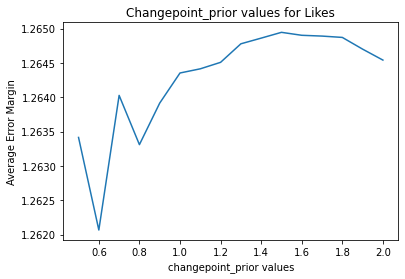

In [238]:
plt.plot(x_replies,avg_replies)
plt.title("Changepoint_prior values for Likes")
plt.xlabel("changepoint_prior values")
plt.ylabel("Average Error Margin")

For Replies, optimal changepoint value is 0.6